# Task 1: Language Modeling

In [2]:
# Imports
from collections import Counter
import re
import math
from tqdm import tqdm # For progress bars

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim

import pandas as pd
from datasets import load_dataset

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


# Set the random seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

## Step 1: EDA

In [17]:
# Fix for google colab
!pip install --upgrade datasets fsspec

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


In [3]:
# Load the dataset
dataset = load_dataset("imdb")
# Inspect the dataset structure
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [13]:
# Prepare the data for language modeling

# We don't need the label (sentiment) for next word prediction, so we'll concat the text fields
train_texts = [review['text'] for review in dataset['train']]

print(f"Loaded {len(train_texts)} reviews.")

# Display the first review
print("First review:\n", train_texts[0])


Loaded 25000 reviews.
First review:
 I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudit

### Data analysis and visualisation

In [14]:
# EDA Tokenization (simple tokenizer to visualize the data)

# Create a tokenizer that removes punctuation and splits by spaces and tokenize the texts
def tokenizer(text):
    # a-z, 0-9, and single apostrophes TODO ??
    text = re.sub(r'[^a-zA-Z0-9\']', ' ', text)
    # Convert to lowercase and split by spaces
    tokens = text.lower().split()
    return tokens

# Tokenize all training texts
all_tokens = [token for text in train_texts for token in tokenizer(text)]

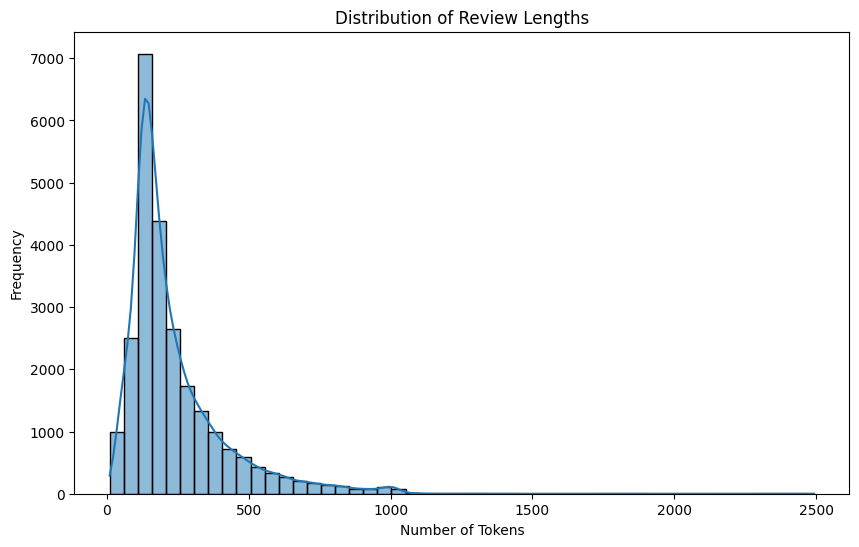

In [21]:
# Review length distribution

# Calculate review lengths for deciding sequence length (what is that?) #TODO
review_lengths = [len(tokenizer(text)) for text in train_texts]

# Plot the distribution of review lengths
plt.figure(figsize=(10, 6))
sns.histplot(review_lengths, bins=50, kde=True)
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()


In [22]:
# Count the frequency of each token
token_counts = Counter(all_tokens)

# Display the 30 most common tokens
most_common_tokens = token_counts.most_common(30)
print("Most common tokens:")
for token, count in most_common_tokens:
    print(f"{token}: {count}")

Most common tokens:
the: 336195
and: 164136
a: 163093
of: 145850
to: 135713
is: 107319
br: 101872
in: 93946
it: 79128
i: 77203
this: 75978
that: 69811
was: 48196
as: 46935
for: 44340
with: 44128
movie: 43573
but: 42618
film: 39104
on: 34194
not: 30619
you: 29895
are: 29431
his: 29370
have: 27727
he: 26962
be: 26949
one: 26519
all: 23963
at: 23515


*Altough it's common to filter stop words, the are crucial for next word prediction so we will keep them

In [16]:
# Creating Train, Validation, and Test Sets

# To create a validation set, we split the original training set
original_train = dataset['train']
train_set, val_set = original_train.train_test_split(test_size=0.1, seed=42).values()

test_set = dataset['test']

print(f"New training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")

New training set size: 22500
Validation set size: 2500
Test set size: 25000


# Step 2: building Dataset & Dataloader

### Vocabulary building

In [17]:
# Building a vocabulary from the training set

# Using the same simple tokenizer from our EDA
def tokenizer(text):
    text = re.sub(r'[^a-zA-Z0-9\']', ' ', text)
    tokens = text.lower().split()
    return tokens

class Vocabulary:
    def __init__(self, min_freq=5):
        self.itos = {0: "<pad>", 1: "<unk>"}  # Index to string mapping
        self.stoi = {"<pad>": 0, "<unk>": 1} # String to index mapping
        self.min_freq = min_freq

    def __len__(self):
        return len(self.itos)

    def build_vocabulary(self, sentence_list):
        # Count all tokens in the training set
        token_counts = Counter()
        print("Building vocabulary...")
        for sentence in tqdm(sentence_list):
            token_counts.update(tokenizer(sentence))

        # Filter by minimum frequency and create mappings
        idx = 2 # Start indexing from 2
        for token, count in token_counts.items():
            if count >= self.min_freq:
                self.stoi[token] = idx
                self.itos[idx] = token
                idx += 1
        print(f"Built vocabulary with {len(self)} words.")


# Create an instance of the Vocabulary class and build it from the training set
vocab = Vocabulary(min_freq=5)
vocab.build_vocabulary(train_set['text'])
'''# Extract the raw text from the train_set for building the vocabulary
train_texts_for_vocab = [example['text'] for example in train_set] TODO test if this works the same
vocab.build_vocabulary(train_texts_for_vocab)'''


Building vocabulary...


100%|██████████| 22500/22500 [00:03<00:00, 7015.77it/s]

Built vocabulary with 29111 words.


"# Extract the raw text from the train_set for building the vocabulary\ntrain_texts_for_vocab = [example['text'] for example in train_set] TODO test if this works the same\nvocab.build_vocabulary(train_texts_for_vocab)"

In [25]:
# Test the vocabulary
print("\n--- Vocabulary Test ---")
print(f"Index of 'movie': {vocab.stoi.get('movie', vocab.stoi['<unk>'])}")
print(f"Index of a rare word 'zombiethon': {vocab.stoi.get('zombiethon', vocab.stoi['<unk>'])}")
print(f"Word for index 10: {vocab.itos.get(10, '<unk>')}")
print("---------------------\n")


--- Vocabulary Test ---
Index of 'movie': 116
Index of a rare word 'zombiethon': 1
Word for index 10: old
---------------------



In [26]:
# Save the vocaulary to be used in Task 2

torch.save(vocab, 'vocab.pth')
print("Vocabulary saved to 'vocab.pth'.")

Vocabulary saved to 'vocab.pth'.


### Dataset and dataloaders

In [18]:
# Define a PyTorch Dataset for the IMDB reviews

class LanguageModelDataset(Dataset):
    def __init__(self, dataset, vocab, max_len=256): # Set a max length
        self.texts = [example['text'] for example in dataset]
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        tokens = tokenizer(text)

        numericalized = [self.vocab.stoi.get(token, self.vocab.stoi["<unk>"]) for token in tokens]

        # --- FIX: Truncate the sequence to max_len ---
        if len(numericalized) > self.max_len:
            numericalized = numericalized[:self.max_len]

        # For language modeling, input is sequence, target is sequence shifted by 1
        input_seq = torch.tensor(numericalized[:-1], dtype=torch.long)
        target_seq = torch.tensor(numericalized[1:], dtype=torch.long)

        return input_seq, target_seq

# Create Dataset objects for training and validation sets
train_dataset = LanguageModelDataset(train_set, vocab, max_len=256)
val_dataset = LanguageModelDataset(val_set, vocab, max_len=256)

# Let's check a sample from the dataset
input_sample, target_sample = train_dataset[0]
print(f"Sample Input Seq: {input_sample[:10]}...")
print(f"Sample Target Seq: {target_sample[:10]}...")


Sample Input Seq: tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11])...
Sample Target Seq: tensor([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12])...


In [19]:
# Define Dataloader

class PadCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        # Separate inputs and targets
        inputs = [item[0] for item in batch]
        targets = [item[1] for item in batch]

        # Pad sequences
        padded_inputs = pad_sequence(inputs, batch_first=True, padding_value=self.pad_idx)
        padded_targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_idx)

        return padded_inputs, padded_targets

# Set hyperparameters
BATCH_SIZE = 32
pad_idx = vocab.stoi["<pad>"]

# Create the DataLoaders
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=PadCollate(pad_idx=pad_idx)
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=PadCollate(pad_idx=pad_idx)
)

print(f"\nCreated DataLoaders with batch size {BATCH_SIZE}.")


Created DataLoaders with batch size 32.


## Step 3: Define and Train the LM
The model will use a RNN and will have the following layers:
-   Embedding Layer:  
    This layer will convert the numerical token indices into dense vector representations, allowing the model to capture semantic meanings of words.
-   LSTM Layer:  
    We'll use an LSTM (Long Short-Term Memory), a powerful type of RNN, to process the sequence of word vectors and capture sequential dependencies.
-   Output (Linear) Layer:  
    This final layer will take the output from the LSTM and predict a probability distribution over our entire vocabulary for the next word in the sequence.

### Model architecture

In [20]:
# Define the architecture of the language model

class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(LanguageModel, self).__init__()

        # 1. Embedding layer to convert token indices to dense vectors
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # 2. LSTM layer to capture sequential patterns
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True  # to make handling batch dimensions easier
        )

        # 3. A fully connected Output layer to predict the next word over the vocabulary
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        # x shape: (batch_size, seq_length)

        embedded = self.embedding(x)
        # embedded shape: (batch_size, seq_length, embedding_dim)

        lstm_out, _ = self.lstm(embedded)
        # lstm_out shape: (batch_size, seq_length, hidden_dim)

        # We pass the output of each time step to the fully connected layer
        out = self.fc(lstm_out)
        # out shape: (batch_size, seq_length, vocab_size)

        return out

# --- Hyperparameters ---
VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_LAYERS = 2
LEARNING_RATE = 0.001

# --- Device Configuration --- (to use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Instantiate the Model ---
model = LanguageModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS).to(device)
print("\nModel Architecture:")
print(model)

Using device: cpu

Model Architecture:
LanguageModel(
  (embedding): Embedding(29111, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=29111, bias=True)
)


### Training loop

In [30]:
# --- Loss and Optimizer ---
# Use CrossEntropyLoss, ignoring the padding token becuase it doesn't contribute to the loss
criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi['<pad>'])
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- Training Loop ---
NUM_EPOCHS = 10
train_losses = []
val_losses = []

print("\n--- Starting Training ---")

for epoch in range(NUM_EPOCHS):
    # --- Training Phase ---
    model.train()
    running_train_loss = 0.0

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Training]"):
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Reshape for loss function:

        outputs_flat = outputs.view(-1, VOCAB_SIZE)
        targets_flat = targets.view(-1)

        # Calculate loss
        loss = criterion(outputs_flat, targets_flat)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Validation Phase ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Validation]"):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)

            outputs_flat = outputs.view(-1, VOCAB_SIZE)
            targets_flat = targets.view(-1)

            loss = criterion(outputs_flat, targets_flat)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

print("--- Finished Training ---")


--- Starting Training ---


Epoch 1/10 [Validation]: 100%|██████████| 79/79 [00:05<00:00, 14.87it/s]


Epoch [1/10], Train Loss: 6.9148, Val Loss: 6.5346


Epoch 2/10 [Validation]: 100%|██████████| 79/79 [00:05<00:00, 15.03it/s]


Epoch [2/10], Train Loss: 6.2630, Val Loss: 6.0163


Epoch 3/10 [Validation]: 100%|██████████| 79/79 [00:05<00:00, 14.83it/s]


Epoch [3/10], Train Loss: 5.9064, Val Loss: 5.7645


Epoch 4/10 [Validation]: 100%|██████████| 79/79 [00:05<00:00, 14.92it/s]


Epoch [4/10], Train Loss: 5.6860, Val Loss: 5.5996


Epoch 5/10 [Validation]: 100%|██████████| 79/79 [00:05<00:00, 14.84it/s]


Epoch [5/10], Train Loss: 5.5293, Val Loss: 5.4914


Epoch 6/10 [Validation]: 100%|██████████| 79/79 [00:05<00:00, 14.68it/s]


Epoch [6/10], Train Loss: 5.4115, Val Loss: 5.4110


Epoch 7/10 [Validation]: 100%|██████████| 79/79 [00:05<00:00, 14.93it/s]


Epoch [7/10], Train Loss: 5.3162, Val Loss: 5.3547


Epoch 8/10 [Validation]: 100%|██████████| 79/79 [00:05<00:00, 14.88it/s]


Epoch [8/10], Train Loss: 5.2317, Val Loss: 5.3080


Epoch 9/10 [Validation]: 100%|██████████| 79/79 [00:05<00:00, 14.68it/s]


Epoch [9/10], Train Loss: 5.1563, Val Loss: 5.2723


Epoch 10/10 [Validation]: 100%|██████████| 79/79 [00:05<00:00, 14.94it/s]

Epoch [10/10], Train Loss: 5.0901, Val Loss: 5.2426
--- Finished Training ---


### Plot losses

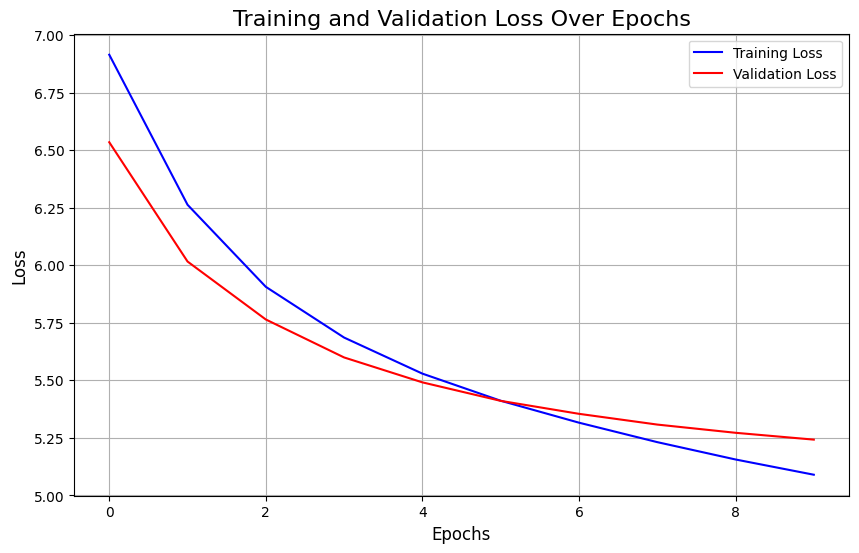

In [31]:
def plot_losses(train_losses, val_losses):
    """
    Plots the training and validation loss curves.
    """
    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Plot training and validation loss
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')

    # Add titles and labels
    plt.title('Training and Validation Loss Over Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)

    # Add a legend to identify the lines
    plt.legend()

    # Add a grid for better readability
    plt.grid(True)

    # Display the plot
    plt.show()

plot_losses(train_losses, val_losses)

# Step 4: Model evaluation

In [ ]:
# Create a Dataset and DataLoader for the test set
test_dataset = LanguageModelDataset(test_set, vocab, max_len=256)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=PadCollate(pad_idx=vocab.stoi["<pad>"])
)

print(f"Created a test DataLoader with {len(test_loader)} batches.")

# Evaluate the trained model on the test loader

def evaluate_perplexity(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
            total_loss += loss.item() * targets.numel()
            total_tokens += targets.numel()
    avg_loss = total_loss / total_tokens
    perplexity = math.exp(avg_loss)
    return perplexity
criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi['<pad>'])
test_perplexity = evaluate_perplexity(loaded_model, test_loader, criterion, device)

print(f"\n--- Final Model Evaluation on Test Set ---")
print(f"Test Perplexity: {test_perplexity:.2f}")
print("------------------------------------------")

Created a test DataLoader with 782 batches.
\n--- Final Model Evaluation on Test Set ---
Test Perplexity: 189.93
------------------------------------------


## Save the model for task 2

In [33]:
# Define a path to save the model
MODEL_SAVE_PATH = 'language_model.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), MODEL_SAVE_PATH)

print(f"Model saved to {MODEL_SAVE_PATH}")

Model saved to language_model.pth
